<a href="https://colab.research.google.com/github/adammoss/MLiS2/blob/master/examples/rnn/cbow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import gensim
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import pandas as pd

In [0]:
sns.set_style("darkgrid")

In [0]:
tf.random.set_seed(1)

In [143]:
print(tf.__version__)

2.1.0


Load Alice in Wonderland corpus

In [0]:
path = keras.utils.get_file('alice.txt', origin='http://www.gutenberg.org/files/11/11-0.txt')
corpus = open(path).readlines()[:1000]
corpus = [sentence for sentence in corpus if sentence.count(' ') >= 2]

In [162]:
print("Nmber of setences: %d" % len(corpus))

Nmber of setences: 763


In [0]:
tokenizer = keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(corpus)
corpus = tokenizer.texts_to_sequences(corpus)
nb_samples = sum(len(s) for s in corpus)
word_dim = len(tokenizer.word_index) + 1
embedding_dim = 50
window_size = 2

In [146]:
print("Found %d unique words" % word_dim)

Found 1670 unique words


In [0]:
def generate_data(corpus, window_size, word_dim):
  maxlen = window_size*2
  for words in corpus:
    L = len(words)
    for index, word in enumerate(words):
      contexts = []
      labels   = []            
      s = index - window_size
      e = index + window_size + 1
      contexts.append([words[i] for i in range(s, e) if 0 <= i < L and i != index])
      labels.append(word)
      x = keras.preprocessing.sequence.pad_sequences(contexts, maxlen=maxlen)
      y = keras.utils.to_categorical(labels, word_dim)
      yield (x, y)

In [0]:
cbow = keras.Sequential()
cbow.add(layers.Embedding(input_dim=word_dim, output_dim=embedding_dim, input_length=window_size*2))
cbow.add(layers.Lambda(lambda x: keras.backend.mean(x, axis=1), output_shape=(embedding_dim,)))
cbow.add(layers.Dense(word_dim, activation='softmax'))

In [149]:
cbow.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 4, 50)             83500     
_________________________________________________________________
lambda_6 (Lambda)            (None, 50)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1670)              85170     
Total params: 168,670
Trainable params: 168,670
Non-trainable params: 0
_________________________________________________________________


In [0]:
cbow.compile(loss='categorical_crossentropy', optimizer='adam')

In [0]:
EPOCHS = 50

In [152]:
for epoch in range(EPOCHS):
    loss = 0.
    for x, y in generate_data(corpus, window_size, word_dim):
        loss += cbow.train_on_batch(x, y)
    print(epoch, loss)

0 60956.90238344669
1 53900.02279514074
2 50723.06730273366
3 47934.5849442482
4 45309.833967886865
5 42775.77981475368
6 40373.641888419166
7 38122.567268683575
8 36016.304894146975
9 34047.865109242965
10 32208.952756148763
11 30489.292821922805
12 28875.449059393723
13 27349.74358373019
14 25901.18210765021
15 24524.107137677027
16 23218.164045992016
17 21987.917958937323
18 20838.936551275663
19 19773.93890939711
20 18793.25276069352
21 17893.553881899687
22 17068.24513838104
23 16311.0064725931
24 15615.35599416538
25 14975.397048127663
26 14385.679147525196
27 13841.391934687534
28 13338.371263700392
29 12873.00139745824
30 12441.669309500488
31 12041.075338870774
32 11668.426724156714
33 11321.276443706702
34 10997.3596588082
35 10694.54284193155
36 10410.913212027412
37 10144.824350830924
38 9894.89574141462
39 9659.910018866622
40 9438.747413970921
41 9230.357172074138
42 9033.676699448204
43 8847.806737677834
44 8671.904963418972
45 8505.28017141492
46 8347.277620613744
47 81

In [153]:
f = open('vectors.txt' ,'w')
f.write('{} {}\n'.format(word_dim-1, embedding_dim))

8

In [0]:
vectors = cbow.get_weights()[0]
for word, i in tokenizer.word_index.items():
    str_vec = ' '.join(map(str, list(vectors[i, :])))
    f.write('{} {}\n'.format(word, str_vec))
f.close()

In [155]:
w2v = gensim.models.KeyedVectors.load_word2vec_format('./vectors.txt', binary=False)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [156]:
w2v.most_similar(positive=['alice'])

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('when', 0.3810272514820099),
 ('child', 0.353360652923584),
 ('certain', 0.3337939977645874),
 ('sternly', 0.33136823773384094),
 ('splendidly', 0.32554909586906433),
 ('returning', 0.3082260191440582),
 ('magpie', 0.3078852891921997),
 ('mouse—of', 0.30231595039367676),
 ('submitted', 0.29560714960098267),
 ('latin', 0.2883782386779785)]

In [0]:
def tsnescatterplot(model, word, embedding_dim):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word, and its list of most similar words
    """
    arrays = np.empty((0, embedding_dim), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)

    # Reduces the dimensionality to 10 dimensions with PCA
    reduc = PCA(n_components=10).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)
    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


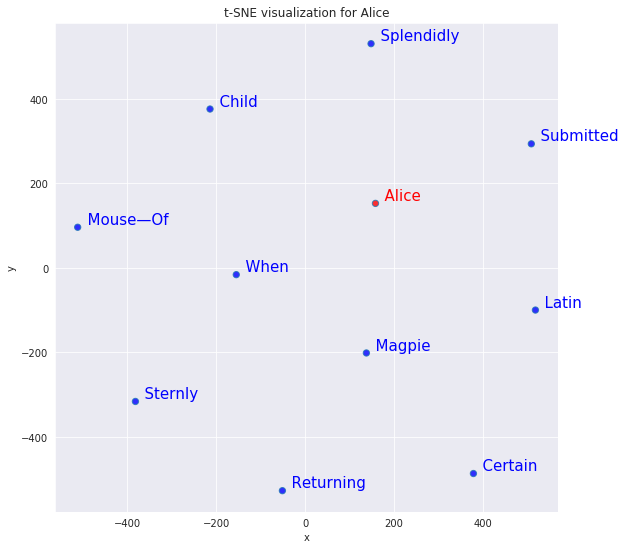

In [158]:
tsnescatterplot(w2v, 'alice', embedding_dim)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


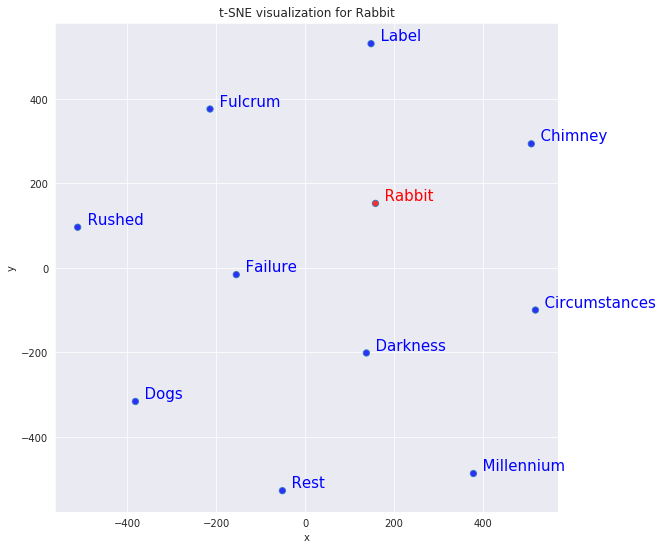

In [159]:
tsnescatterplot(w2v, 'rabbit', embedding_dim)